In [59]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import jax

from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

from data import generate_data
from loss import create_loss
from network import init_net_orth, compute_end_to_end, compute_factor, compress_network
from solver import train
from utils import compose, svd

In [5]:
key = PRNGKey(0)

# Simulated Data
d = 1000
r = 10

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

loss_fn = create_loss(target)
e2e_loss_fn = compose(loss_fn, compute_end_to_end)

In [6]:
depth = 3
init_type = "orth"
init_scale = 1e-3

key, subkey = split(key)
init_weights = init_net_orth(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-10
step_size = 1e3
n_outer_loops = 5000
n_inner_loops = 200

In [7]:
orig_step_size = step_size
orig_result = train(
    init_weights=init_weights,
    train_e2e_loss_fn=e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=orig_step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
V = compute_factor(init_weights=init_weights, e2e_loss_fn=e2e_loss_fn, grad_rank=r)
comp_init_weights = compress_network(init_weights=init_weights, V=V, grad_rank=r)

In [52]:
prop = 0
comp_step_size = [prop * step_size] + (depth * [step_size]) + [prop * step_size]
comp_result = train(
    init_weights=comp_init_weights,
    train_e2e_loss_fn=e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=comp_step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [60]:
orig_weights = orig_result['weights']
comp_weights = comp_result['weights']
orig_end_to_end = [compute_end_to_end(w).reshape(-1) for w in orig_weights]
comp_end_to_end = [compute_end_to_end(w).reshape(-1) for w in comp_weights]
optimal_e2e = orig_end_to_end[-1]

displacement = orig_end_to_end[0] - optimal_e2e
most_changing_indices = jnp.argpartition(displacement, -2)[-2:]
proj = jnp.zeros(shape=(d**2, 2)).at[most_changing_indices, jnp.arange(2)].set(1)

In [66]:
triples = []
for e2e in orig_end_to_end:
    pairs = proj.T @ (e2e - optimal_e2e)
    fval = loss_fn(e2e.reshape(d, d))
    triples.append([*pairs, fval])
triples = jnp.array(triples)

In [62]:
t1vals = jnp.linspace(-2, 2)
t2vals = jnp.linspace(-1.5, 1.5)
lossvals = []
for t1 in tqdm(t1vals):
    row = []
    for t2 in t2vals:
        point = (optimal_e2e + t1 * proj[:, 0] + t2 * proj[:, 1]).reshape(d, d)
        row.append(loss_fn(point))
        
    lossvals.append(row)
    
lossvals = jnp.array(lossvals)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.65it/s]


In [69]:
triples.shape

(102, 3)

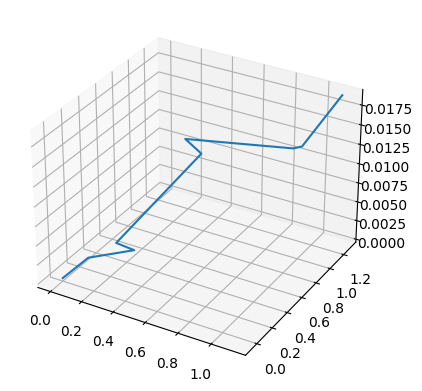

In [70]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(triples[:, 0], triples[:, 1], triples[:, 2])

In [63]:
pairs.shape

(102, 2)

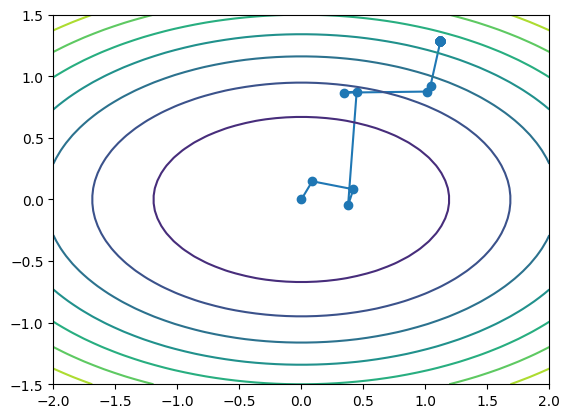

In [64]:
plt.plot(pairs[:, 0], pairs[:, 1], '-o')
plt.contour(t1vals, t2vals, lossvals)

In [58]:
pairs[0]

Array([1.12197717, 1.2854225 ], dtype=float64)

In [22]:
displacement[jnp.argpartition(displacement, -2)[-2:]]

Array([1.12197717, 1.2854225 ], dtype=float64)

In [19]:
first_dir[jnp.argmax(jnp.abs(first_dir))]

Array(1.2854225, dtype=float64)

In [43]:
tvals = jnp.linspace(-1, 1)
lossvals = []
for t1 in tvals:
    row = []
    for t2 in tvals:
        row.append(loss_fn(optimal_e2e + t1 * random_dir_1 + t2 * random_dir_2))
        
    lossvals.append(row)
    
lossvals = jnp.array(lossvals)

In [44]:
lossvals.shape

(50, 50)

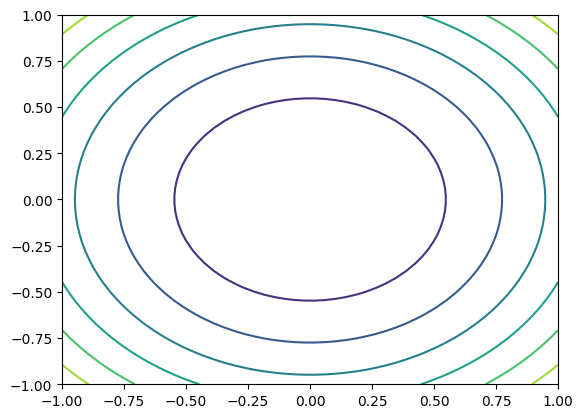

In [45]:
plt.contour(tvals, tvals, lossvals)

In [16]:
[loss_fn(e2e) for e2e in orig_end_to_end]

[Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, dtype=float64),
 Array(0.01906219, d

In [ ]:
A = jnp.linalg.svd(generate_data(key=PRNGKey(11), shape=(3, d*d)), full_matrices=False)[2]

In [ ]:
red_orig_end_to_end = jnp.array([A @ w for w in orig_end_to_end])
red_comp_end_to_end = jnp.array([A @ w for w in comp_end_to_end])

In [ ]:
fig = plt.figure(figsize=(13, 5))

ax = fig.add_subplot(121, projection='3d')

ax.plot(red_orig_end_to_end[:, 0], red_orig_end_to_end[:, 1], red_orig_end_to_end[:, 2], linewidth=5, linestyle='--', label='Original')
ax.plot(red_comp_end_to_end[:, 0], red_comp_end_to_end[:, 1], red_comp_end_to_end[:, 2], linewidth=3, linestyle='-', label='Compressed')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.legend(fontsize=12)
ax.set_box_aspect(None, zoom=1.2)

ax = fig.add_subplot(122)

ax.semilogy(orig_result['time'], orig_result['train_loss'], linewidth=5, label='Original')
ax.semilogy(comp_result['time'], comp_result['train_loss'], linewidth=3, label='Compressed')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.legend(fontsize=12)

# plt.savefig('figs/equiv_traj_l2.png', dpi=300, bbox_inches='tight')